# Food Recipe Retrieval
#### Christopher Le cl7, Matheus Rempel mmr13

### **1. Food101 Dataset**

Insert description

In [6]:
import os, json, pickle, random, torch
import shutil
import torch.utils.data
!pip install pillow
from PIL import Image
!pip install matplotlib

#### 1.1 Extracting the dataset (stored locally)

In [14]:
# Run only once locally to extract the files
# !tar xf food-101.tar.gz

tar: Error opening archive: Failed to open 'food-101.tar.gz'


#### 1.2 Splitting the dataset into training/testing folders

The dataset is contained entirely in one folder. We split the data into train/test folders using the provided train.txt and test.txt as reference

In [17]:
# Create new train/test directories
def create_dir(leaf):
    '''
    Create new train/test directories if they do not exist
    '''
    dataset_directory = 'food-101'
    if os.path.exists(os.path.join(dataset_directory, leaf)):
        return
    os.makedirs(os.path.join(dataset_directory, leaf))

#create_dir('train')
#create_dir('test')

In [18]:
# Copying the images to the designated folder according to train.txt or test.txt
def move_files(which_folder):
    '''
    Moves the images from food-101/images to food-101/train or food-101/test depending on input
    '''
    if which_folder not in ['train', 'test']:
        print('Invalid folder')
        return
    
    main_dir = 'food-101/'
    meta_dir = 'food-101/meta/'
    img_dir = 'food-101/images/'
    move_dir = 'food-101/' + which_folder + '/'
    
    with open(meta_dir + which_folder + '.txt', 'r') as file:
        img_paths = file.readlines()
        img_paths = [path.strip() for path in img_paths]
    for path in img_paths:
        category = path.split('/')[0]
        if not os.path.exists(move_dir + category):
            os.makedirs(move_dir + category)
        shutil.copy(img_dir + path + '.jpg', move_dir + path + '.jpg')
        
#move_files('train')
#move_files('test')

#### 1.3 Creating the custom dataloader for the dataset

In [19]:
# Simple implementation of a custom data loading class for our SUN20 dataset.
class food101(torch.utils.data.Dataset):

    # Initialize the class e.g. load files, preprocess, etc.
    def __init__(self, split = 'train', transform = None):

        # 101 food categories (self.nlcategories are the categories in natural language)
        self.categories = open('food-101/meta/classes.txt').read().split('\n')[:-1]
        self.categories = sorted(self.categories)
        self.category2index = {category: idx for (idx, category) in enumerate(self.categories)}
        self.nlcategories = open('food-101/meta/labels.txt').read().split('\n')[:-1]
        self.nlcategories = sorted(self.nlcategories)
        self.nlcategory2index = {category: idx for (idx, category) in enumerate(self.nlcategories)}
        self.transform = transform

        # Compile a list of images and corresponding labels.
        self.imagepaths = []
        self.labels = []
        for category in self.categories:
            category_directory = 'food-101/' + split + '/' + category
            category_imagenames = os.listdir(category_directory)
            self.imagepaths += [os.path.join(category_directory, imagename) 
                                for imagename in category_imagenames]
            self.labels += [self.category2index[category]] * len(category_imagenames)

        # Sort imagepaths alphabetically and labels accordingly.
        sorted_pairs = sorted(zip(self.imagepaths, self.labels), key = lambda x: x[0])
        self.imagepaths, self.labels = zip(*sorted_pairs)


    # Return a sample (x, y) as a tuple e.g. (image, label)
    def __getitem__(self, index):
        image = Image.open(self.imagepaths[index]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[index]

    # Return the total number of samples.
    def __len__(self):
        return len(self.imagepaths)

#### 1.4 Using the custom dataloader

This dataset has 75750 training images
Image 40000 is a hamburger
Image size is 512x512


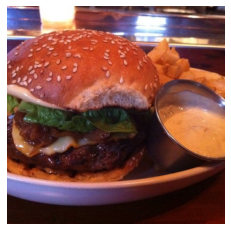

In [20]:
# Displaying a sample image
import matplotlib
import matplotlib.pyplot as plt

image_index = 40000  # Feel free to change this.

def display_food(image_index=0):
    
    trainset = food101(split = 'train')
    
    # 1. Datasets need to implement the __len__ method for this to work.
    print('This dataset has {0} training images'.format(len(trainset)))

    # 2. Datasets need to implement the  __getitem__ method for this to work.
    img, label = trainset[image_index]  # Returns image and label.

    print('Image {0} is a {1}'.format(image_index, trainset.categories[label]))
    print('Image size is {0}x{1}'.format(img.height, img.width))

    # Show the image.
    plt.figure();plt.imshow(img);
    plt.grid(False); plt.axis('off'); plt.show()

display_food(image_index)

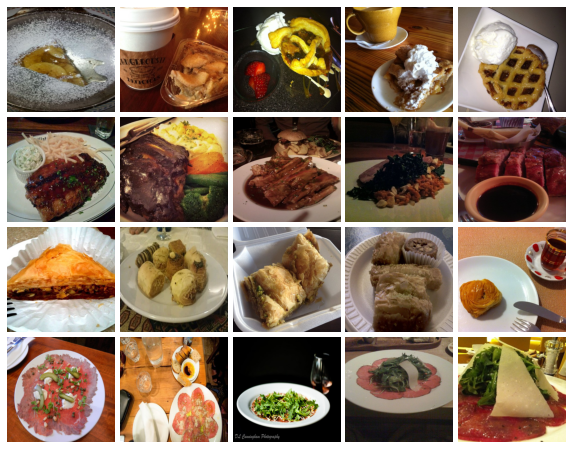

In [21]:
# Displaying sample images from some classes
import matplotlib
import matplotlib.pyplot as plt

def plot_images():
    trainset = food101(split='train')

    # Collecting all the indices containing images for the category
    valid_img_idxs = [0, 1, 2, 3, 4, 750, 751, 752, 753, 754, 
                      1500, 1501, 1502, 1503, 1504, 2250, 2251, 2252, 2253, 2254, ]

    # Creating the 4x12 subplots for each image
    fig, axs = plt.subplots(4, 5, figsize=(10, 8))
    for i in range(4):
        for j in range(5):
            img, label = trainset[valid_img_idxs[i*5 + j]]
            axs[i][j].imshow(img, aspect='auto')  # 'auto' aspect to keep sizes consistent
            axs[i][j].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
plot_images()

### **2. CLIP-Based Classification**

Here we evaluate the effectiveness of the CLIP model on the testing set by measuring the predictive accuracy.

#### 2.1 Installing CLIP dependencies

In [77]:
# Installing the dependencies
#!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/pb/hcdg70mj46zcylltkl_ls8xc0000gn/T/pip-req-build-7v6nv4av
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/pb/hcdg70mj46zcylltkl_ls8xc0000gn/T/pip-req-build-7v6nv4av
  Resolved https://github.com/openai/CLIP.git to commit b4ae44927b78d0093b556e3ce43cbdcff422017a
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369376 sha256=b200074dc642b2ab666366ae67c5ee05bf72f75d4ea2a62ba9d242178f385bd4
  Stored in directory: /private/var/folders/pb/hcdg70mj46zcylltkl_ls8xc0000gn/T/pip-ephem-wheel-cache-xk_1syt7/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [78]:
# Displaying the labels to be used with the CLIP classifier
food101set = food101(split='test')
food101set.nlcategories

['Apple pie',
 'Baby back ribs',
 'Baklava',
 'Beef carpaccio',
 'Beef tartare',
 'Beet salad',
 'Beignets',
 'Bibimbap',
 'Bread pudding',
 'Breakfast burrito',
 'Bruschetta',
 'Caesar salad',
 'Cannoli',
 'Caprese salad',
 'Carrot cake',
 'Ceviche',
 'Cheese plate',
 'Cheesecake',
 'Chicken curry',
 'Chicken quesadilla',
 'Chicken wings',
 'Chocolate cake',
 'Chocolate mousse',
 'Churros',
 'Clam chowder',
 'Club sandwich',
 'Crab cakes',
 'Creme brulee',
 'Croque madame',
 'Cup cakes',
 'Deviled eggs',
 'Donuts',
 'Dumplings',
 'Edamame',
 'Eggs benedict',
 'Escargots',
 'Falafel',
 'Filet mignon',
 'Fish and chips',
 'Foie gras',
 'French fries',
 'French onion soup',
 'French toast',
 'Fried calamari',
 'Fried rice',
 'Frozen yogurt',
 'Garlic bread',
 'Gnocchi',
 'Greek salad',
 'Grilled cheese sandwich',
 'Grilled salmon',
 'Guacamole',
 'Gyoza',
 'Hamburger',
 'Hot and sour soup',
 'Hot dog',
 'Huevos rancheros',
 'Hummus',
 'Ice cream',
 'Lasagna',
 'Lobster bisque',
 'Lobster

#### 2.2 Evaluating CLIP (ViT-B/32 model) on testing set

Top 1 Accuracy

In [79]:
# Checking the overall predictive accuracy of the CLIP model on the validation set
# Load the model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
food101set = food101(split='test')
cats = food101set.nlcategories

# Loop through each image in the validation set and calculate the overall accuracy
import time
start = time.time()

prev_class_id = None
correct = 0
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
for idx in range(len(food101set)):
    image, class_id = food101set[idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    # Compute whether the prediction is correct, and keep a running total of correct guesses
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
    _, pred_id = similarity[0].max(0)
    correct += (class_id == pred_id.item()) * 1
    # if class_id != pred_id.item():
    #     print(cats[class_id], cats[pred_id])
    if class_id != prev_class_id:
        prev_class_id = class_id
        print('Now predicting {} labels'.format(class_id))
    
accuracy = correct / len(food101set)
end = time.time()
print('Time elapsed: ', end - start)
print('Accuracy on validation set: ', accuracy)

100%|███████████████████████████████████████| 338M/338M [00:12<00:00, 28.0MiB/s]


Now predicting 0 labels
Now predicting 1 labels
Now predicting 2 labels
Now predicting 3 labels
Now predicting 4 labels
Now predicting 5 labels


KeyboardInterrupt: 

#### 2.3 Evaluating CLIP (ViT-B/32 model) on testing set

Top 5 Accuracy

In [4]:
# Checking the top-5 predictive accuracy of the CLIP model on the validation set
# Load the model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
food101set = food101(split='test')
cats = food101set.nlcategories

# Loop through each image in the validation set and calculate the overall accuracy
import time
start = time.time()

prev_class_id = None
correct = 0
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
for idx in range(len(food101set)):
    image, class_id = food101set[idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    # Compute whether the prediction is correct, and keep a running total of correct guesses
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
    _, pred_id = similarity[0].topk(5)
    correct += (class_id in pred_id) * 1
    if class_id != prev_class_id:
        prev_class_id = class_id
        print('Now predicting {} labels'.format(class_id))
    
accuracy = correct / len(food101set)
end = time.time()
print('Time elapsed: ', end - start)
print('Accuracy on validation set: ', accuracy)

Now predicting 0 labels
Now predicting 1 labels
Now predicting 2 labels
Now predicting 3 labels
Now predicting 4 labels
Now predicting 5 labels
Now predicting 6 labels
Now predicting 7 labels
Now predicting 8 labels
Now predicting 9 labels
Now predicting 10 labels
Now predicting 11 labels
Now predicting 12 labels
Now predicting 13 labels
Now predicting 14 labels
Now predicting 15 labels
Now predicting 16 labels
Now predicting 17 labels
Now predicting 18 labels
Now predicting 19 labels
Now predicting 20 labels
Now predicting 21 labels
Now predicting 22 labels
Now predicting 23 labels
Now predicting 24 labels
Now predicting 25 labels
Now predicting 26 labels
Now predicting 27 labels
Now predicting 28 labels
Now predicting 29 labels
Now predicting 30 labels
Now predicting 31 labels
Now predicting 32 labels
Now predicting 33 labels
Now predicting 34 labels
Now predicting 35 labels
Now predicting 36 labels
Now predicting 37 labels
Now predicting 38 labels
Now predicting 39 labels
Now predic

#### 2.4 Evaluating CLIP (ViT-L/14 model) on testing set

Top 1 Accuracy

In [3]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [12]:
# Checking the predictive accuracy of CLIP ViT-L/14
# Load the model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

# Load the dataset
food101set = food101(split='test')
cats = food101set.nlcategories

# Loop through each image in the validation set and calculate the overall accuracy
import time
start = time.time()

prev_class_id = None
mismatch = {}
correct = 0
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
for idx in range(len(food101set)):
    image, class_id = food101set[idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    # Compute whether the prediction is correct, and keep a running total of correct guesses
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
    _, pred_id = similarity[0].max(0)
    correct += (class_id == pred_id.item()) * 1
    if class_id != pred_id.item():
        if (cats[class_id], cats[pred_id]) in mismatch:
            mismatch[(cats[class_id], cats[pred_id])] += 1
        else:
            mismatch[(cats[class_id], cats[pred_id])] = 1
    if class_id != prev_class_id:
        prev_class_id = class_id
        print('Now predicting {} labels'.format(class_id))
    
accuracy = correct / len(food101set)
end = time.time()
print('Time elapsed: ', end - start)
print('Accuracy on validation set: ', accuracy)

Now predicting 0 labels
Now predicting 1 labels
Now predicting 2 labels
Now predicting 3 labels
Now predicting 4 labels
Now predicting 5 labels
Now predicting 6 labels
Now predicting 7 labels
Now predicting 8 labels
Now predicting 9 labels
Now predicting 10 labels
Now predicting 11 labels
Now predicting 12 labels
Now predicting 13 labels
Now predicting 14 labels
Now predicting 15 labels
Now predicting 16 labels
Now predicting 17 labels
Now predicting 18 labels
Now predicting 19 labels
Now predicting 20 labels
Now predicting 21 labels
Now predicting 22 labels
Now predicting 23 labels
Now predicting 24 labels
Now predicting 25 labels
Now predicting 26 labels
Now predicting 27 labels
Now predicting 28 labels
Now predicting 29 labels
Now predicting 30 labels
Now predicting 31 labels
Now predicting 32 labels
Now predicting 33 labels
Now predicting 34 labels
Now predicting 35 labels
Now predicting 36 labels
Now predicting 37 labels
Now predicting 38 labels
Now predicting 39 labels
Now predic

In [25]:
# Displaying the top mismatches
mismatch_list = [(x, y) for (x, y) in mismatch.items()]
mismatch_list.sort(key=lambda x: x[1], reverse=True)
mismatch_list[:20]

[(('Steak', 'Filet mignon'), 67),
 (('Ravioli', 'Gnocchi'), 54),
 (('Chocolate cake', 'Chocolate mousse'), 50),
 (('Cup cakes', 'Red velvet cake'), 30),
 (('Onion rings', 'Fried calamari'), 28),
 (('Donuts', 'Beignets'), 27),
 (('Sushi', 'Sashimi'), 26),
 (('Apple pie', 'Bread pudding'), 22),
 (('Macaroni and cheese', 'Gnocchi'), 22),
 (('Tuna tartare', 'Beef tartare'), 22),
 (('Clam chowder', 'Lobster bisque'), 21),
 (('Ice cream', 'Frozen yogurt'), 21),
 (('Prime rib', 'Steak'), 21),
 (('Pork chop', 'Foie gras'), 18),
 (('Tuna tartare', 'Ceviche'), 17),
 (('Garlic bread', 'Bruschetta'), 16),
 (('Beef tartare', 'Tuna tartare'), 15),
 (('French onion soup', 'Creme brulee'), 15),
 (('Spaghetti bolognese', 'Spaghetti carbonara'), 15),
 (('Carrot cake', 'Bread pudding'), 14)]

#### 2.5 Evaluating CLIP (ViT-L/14 model) on testing set

Top 5 Accuracy

In [29]:
# Checking the predictive accuracy of CLIP ViT-L/14
# Load the model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

# Load the dataset
food101set = food101(split='test')
cats = food101set.nlcategories

# Loop through each image in the validation set and calculate the overall accuracy
import time
start = time.time()

prev_class_id = None
mismatch = []
correct = 0
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
for idx in range(len(food101set)):
    image, class_id = food101set[idx]
    image_input = preprocess(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image_input)

    # Compute whether the prediction is correct, and keep a running total of correct guesses
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
    _, pred_id = similarity[0].topk(5)
    correct += (class_id in pred_id) * 1
    if class_id not in pred_id:
        mismatch.append((class_id, pred_id))
    if class_id != prev_class_id:
        prev_class_id = class_id
        print('Now predicting {} labels'.format(class_id))
        
        
    
accuracy = correct / len(food101set)
end = time.time()
print('Time elapsed: ', end - start)
print('Accuracy on validation set: ', accuracy)

Now predicting 0 labels
Now predicting 1 labels
Now predicting 2 labels
Now predicting 3 labels
Now predicting 4 labels
Now predicting 5 labels
Now predicting 6 labels
Now predicting 7 labels
Now predicting 8 labels
Now predicting 9 labels
Now predicting 10 labels
Now predicting 11 labels
Now predicting 12 labels
Now predicting 13 labels
Now predicting 14 labels
Now predicting 15 labels
Now predicting 16 labels
Now predicting 17 labels
Now predicting 18 labels
Now predicting 19 labels
Now predicting 20 labels
Now predicting 21 labels
Now predicting 22 labels
Now predicting 23 labels
Now predicting 24 labels
Now predicting 25 labels
Now predicting 26 labels
Now predicting 27 labels
Now predicting 28 labels
Now predicting 29 labels
Now predicting 30 labels
Now predicting 31 labels
Now predicting 32 labels
Now predicting 33 labels
Now predicting 34 labels
Now predicting 35 labels
Now predicting 36 labels
Now predicting 37 labels
Now predicting 38 labels
Now predicting 39 labels
Now predic

In [32]:
print(len(mismatch))

204


### **3. Using CLIP for prediction**

#### 3.1 Creating Inputs for predict_food() function

In [80]:
# Installing the dependencies
!pip install ftfy regex tqdm --quiet
!pip install git+https://github.com/openai/CLIP.git --quiet

# Load the model
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

# Encode all the food categories to be used by the model
# Load all food categories
cats = ['Apple pie', 'Baby back ribs', 'Baklava', 'Beef carpaccio', 'Beef tartare', 
        'Beet salad', 'Beignets', 'Bibimbap', 'Bread pudding', 'Breakfast burrito', 
        'Bruschetta', 'Caesar salad', 'Cannoli', 'Caprese salad', 'Carrot cake', 'Ceviche', 
        'Cheese plate', 'Cheesecake', 'Chicken curry', 'Chicken quesadilla', 'Chicken wings', 
        'Chocolate cake', 'Chocolate mousse', 'Churros', 'Clam chowder', 'Club sandwich', 
        'Crab cakes', 'Creme brulee', 'Croque madame', 'Cup cakes', 'Deviled eggs', 'Donuts', 
        'Dumplings', 'Edamame', 'Eggs benedict', 'Escargots', 'Falafel', 'Filet mignon', 
        'Fish and chips', 'Foie gras', 'French fries', 'French onion soup', 'French toast', 
        'Fried calamari', 'Fried rice', 'Frozen yogurt', 'Garlic bread', 'Gnocchi', 'Greek salad', 
        'Grilled cheese sandwich', 'Grilled salmon', 'Guacamole', 'Gyoza', 'Hamburger', 
        'Hot and sour soup', 'Hot dog', 'Huevos rancheros', 'Hummus', 'Ice cream', 'Lasagna', 
        'Lobster bisque', 'Lobster roll sandwich', 'Macaroni and cheese', 'Macarons', 'Miso soup', 
        'Mussels', 'Nachos', 'Omelette', 'Onion rings', 'Oysters', 'Pad thai', 'Paella', 
        'Pancakes', 'Panna cotta', 'Peking duck', 'Pho', 'Pizza', 'Pork chop', 'Poutine', 
        'Prime rib', 'Pulled pork sandwich', 'Ramen', 'Ravioli', 'Red velvet cake', 'Risotto', 
        'Samosa', 'Sashimi', 'Scallops', 'Seaweed salad', 'Shrimp and grits', 'Spaghetti bolognese', 
        'Spaghetti carbonara', 'Spring rolls', 'Steak', 'Strawberry shortcake', 'Sushi', 'Tacos', 
        'Takoyaki', 'Tiramisu', 'Tuna tartare', 'Waffles']
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cats]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    
print('done')

100%|███████████████████████████████████████| 890M/890M [02:42<00:00, 5.75MiB/s]


done


#### 3.2 Creating the function which predicts the food class given an image input

In [81]:
def predict_food(image, cats, model, preprocess, text_features):
    """
    Predicts the top 3 classification predictions for an input image
        Input:  img: RGB PIL.Image.Image file
                cats: Food categories (From previous cell)
                model: CLIP model (From previous cell)
                preprocess: CLIP model preprocessing tools (From previous cell)
                text_features: Encoded output categories to be used as predictors (From previous cell)
                
        Output: List of top 3 food class predictions (ordered)
    """
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    
    with torch.no_grad():
        image_input = preprocess(image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_input)
        
    # Compute the predictions
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    score, pred_id = similarity[0].topk(3)
    
    predictions = [cats[idx] for idx in list(pred_id)]
    return score.tolist(), predictions


    
# # Testing
# food101set = food101(split='test')
# image, _ = food101set[500]
# scores, predictions = predict_food(image, cats, model, preprocess, text_features)
# print('Predictions:')
# for i in range(len(predictions)):
#     print(predictions[i], '\t', scores[i])
# image

#### 3.3 Using the function without the data loader

Predictions:
Pizza 	 0.5969898700714111
Bruschetta 	 0.31708917021751404
Grilled cheese sandwich 	 0.04140237346291542


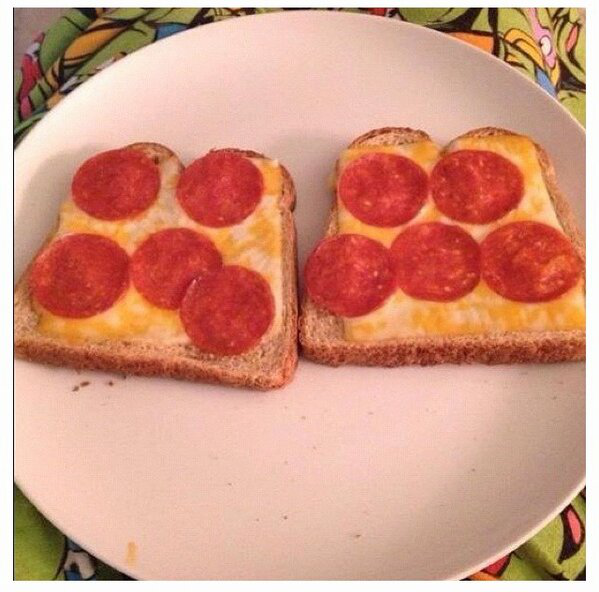

In [92]:
# Test code that does not use the data loader 
file_path = 'BDVEWyECUAEe2Lf.jpeg'
image = Image.open(file_path).convert('RGB')
scores, predictions = predict_food(image, cats, model, preprocess, text_features)
print('Predictions:')
for i in range(len(predictions)):
    print(predictions[i], '\t', scores[i])
image